In [1]:
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import numpy as np

In [2]:
# data_samp_path = '/Users/kuba/Documents/data/raw/kuba_twp5_watchdata_nov19/2024-09-10_12_42_48'
data_samp_path = '/home/kuba/Documents/data/raw/kuba_watch_data/2024-07-10_06_42_46'


WINDOW_SIZE = 400
STRIDE = 50

In [3]:
#accl
accl_path = os.path.join(data_samp_path, "acceleration.csv")
#gyro
gyro_path = os.path.join(data_samp_path, "gyroscope.csv")

acc = pd.read_csv(accl_path, skiprows=1)
acc['timestamp']  = (acc['timestamp'] - acc['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
#first_row_acc = get_first_line(os.path.join(full_path, 'acceleration.csv'))

gyro = pd.read_csv(gyro_path, skiprows=1)
gyro['timestamp']  = (gyro['timestamp'] - gyro['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
#first_row_gyro = get_first_line(os.path.join(full_path, 'gyroscope.csv'))

In [4]:
len(acc) / 350

7417.065714285714

In [5]:
x, y, z = acc['x'].to_numpy(), acc['y'].to_numpy(), acc['z'].to_numpy()

In [6]:
max = 100000

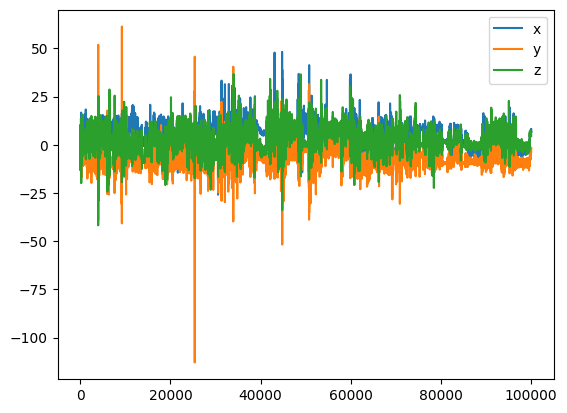

In [7]:
plt.plot(x[:max], label='x')
plt.plot(y[:max], label='y')
plt.plot(z[:max], label='z')
plt.legend()

LETS NOW MAKE SOME DATA TO PASS TO THE NN

In [8]:
def window_maker(data, window_size, stride, flatten):
    """Create windows from time series data."""
    windows = []
    
    if flatten:
        # Flatten x, y, z channels into a single vector per window
        for i in range(0, len(data['x']) - window_size + 1, stride):
            window = []
            window.extend(data['x'][i:i + window_size].tolist())
            window.extend(data['y'][i:i + window_size].tolist())
            window.extend(data['z'][i:i + window_size].tolist())
            windows.append(window)
    else:
        # Keep x, y, z as separate channels
        for i in range(0, len(data['x']) - window_size + 1, stride):
            window = [
                data['x'][i:i + window_size].tolist(),
                data['y'][i:i + window_size].tolist(),
                data['z'][i:i + window_size].tolist()
            ]
            windows.append(window)
            
    return windows


def process_recording(acc_data, gyro_data, window_size, stride, flatten):
    """Extract activity windows and labels from a recording."""

    if len(acc) >= window_size:
        acc_windows_batch = window_maker(acc_data, window_size, stride, flatten)
        gyro_windows_batch = window_maker(gyro_data, window_size, stride, flatten)

        # Handle potential mismatch in window counts
        min_windows = min(len(acc_windows_batch), len(gyro_windows_batch))
        acc_windows_batch = acc_windows_batch[:min_windows]
        gyro_windows_batch = gyro_windows_batch[:min_windows]
    
    return torch.tensor(acc_windows_batch), torch.tensor(gyro_windows_batch)

In [9]:
acc_windows, gyro_windows = process_recording(acc, gyro, window_size=WINDOW_SIZE, stride=STRIDE, flatten=False)
acc_windows.shape, gyro_windows.shape

(torch.Size([51912, 3, 400]), torch.Size([51912, 3, 400]))

In [10]:
all_windows = torch.cat((acc_windows, gyro_windows), dim=1)
all_windows.shape

torch.Size([51912, 6, 400])

now lets define the model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class simple_cnn(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.c0  = nn.Conv1d(6, 64, kernel_size=3, stride=2)

        self.c1  = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.c2  = nn.Conv1d(128, 128, kernel_size=3)

        self.c3  = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        self.c4  = nn.Conv1d(256, 256, kernel_size=3)
        self.c5  = nn.Conv1d(256, 256, kernel_size=3)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.l0 = nn.Linear(256,256)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(256,1)
            
        
    def forward(self, x):
        x = F.relu(self.c0(x), inplace=True)
        
        x = F.relu(self.c1(x), inplace=True)
        x = F.relu(self.c2(x), inplace=True)
        
        x = F.relu(self.c3(x), inplace=True)
        x = F.relu(self.c4(x), inplace=True)
        x = F.relu(self.c5(x), inplace=True)
        
        x = self.gap(x).squeeze(-1)
        x = F.relu(self.l0(x), inplace=True)
        x = self.dropout(x)
        x = self.out(x)
        
        return x


In [12]:
model = simple_cnn()
model.load_state_dict(torch.load('/home/kuba/projects/medication-taking-data/new_start/week02/94f1_fullleak01.pth', weights_only=True))


# from RegNet import RegNet
# model = RegNet()
# model.load_state_dict(torch.load('/home/kuba/projects/medication-taking-data/new_start/week02/88f1_fullleak_YESstatic.pth', weights_only=True))

<All keys matched successfully>

In [13]:
device = 'cuda:0'
model = model.to(device)
all_windows = all_windows.to(device)
with torch.no_grad():
    model.eval()
    logits = model(all_windows)

The model was trained to where:
0 = daily life 
1 = medication 

In [14]:
preds = F.sigmoid(logits.cpu())
preds

tensor([[6.3769e-28],
        [1.7568e-21],
        [1.0196e-20],
        ...,
        [2.4496e-04],
        [2.4380e-17],
        [2.4143e-02]])

In [15]:
preds_list = preds.tolist()
preds_list = [val[0] for val in preds_list]
preds_list.reverse()

In [16]:
len(preds_list)

51912

In [17]:
len(acc)

2595973

In [18]:
counts = np.zeros((len(acc)))
sums = np.zeros((len(acc)))

counts.shape, sums.shape

((2595973,), (2595973,))

In [19]:
len_to_use = min(len(acc) - WINDOW_SIZE, len(gyro) - WINDOW_SIZE) #Handle potential mismatch in window count
for i in range(0, len_to_use, STRIDE):
    val = preds_list.pop()
    sums[i : i+WINDOW_SIZE] += val
    counts[i : i+WINDOW_SIZE] += 1


In [20]:
def smooth_predictions(prediction_sum, counts):
    """
    Smooth predictions by averaging, handling divisions by zero.
    """

    averaged_predictions = prediction_sum / (counts + 0.00001)
    return averaged_predictions


In [21]:
avg_preds = smooth_predictions(sums, counts)

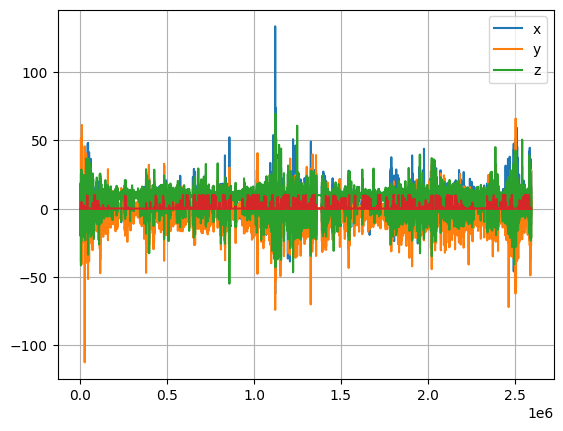

In [22]:
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(z, label='z')
plt.plot((avg_preds * 10))
plt.grid()
plt.legend()

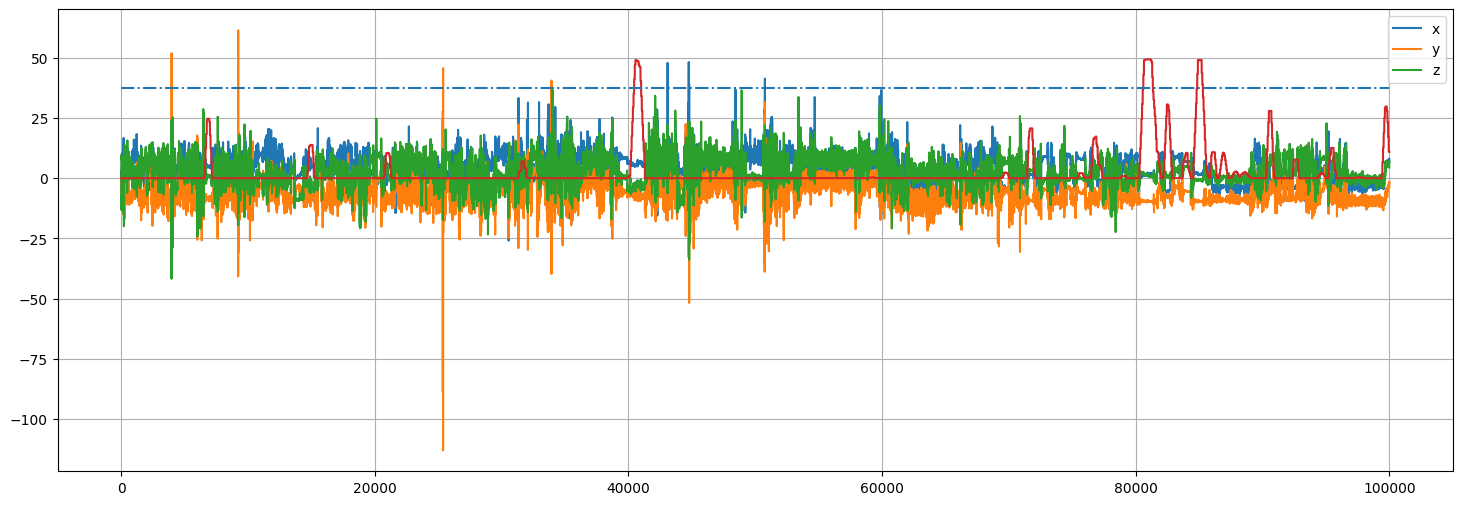

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))

# Then do your plotting
ax.plot(x[:max], label='x')
ax.plot(y[:max], label='y')
ax.plot(z[:max], label='z')
ax.plot((avg_preds[:max] * 50))
ax.hlines([(0.75 * 50)],xmin=0, xmax=len(x[:max]), linestyles='dashdot')
ax.grid()
ax.legend()

# Show or save the figure
plt.show()

In [24]:
def count_medication_taking_predictions(avg_preds, conf_threshold=0.80):
    count = 0
    total_num_windows = 0
    for i in range(0, len(avg_preds) - WINDOW_SIZE, WINDOW_SIZE):
        total_num_windows += 1
        window = avg_preds[i: i + WINDOW_SIZE]
        print(np.mean(window), "  ", i, ":", i+WINDOW_SIZE)
        if np.mean(window) >= conf_threshold :
            count += 1

        
    print(f"There is {count} of {total_num_windows} predictions over the confidance threshold({conf_threshold})")

In [25]:
len(avg_preds[:max]), len(avg_preds)

(100000, 2595973)

In [26]:
count_medication_taking_predictions(avg_preds)

4.459107119857832e-17    0 : 400
2.1625807532750872e-13    400 : 800
3.291895293521708e-13    800 : 1200
5.745233073384385e-10    1200 : 1600
6.109051890098969e-09    1600 : 2000
3.462168646305105e-08    2000 : 2400
4.174485216069168e-09    2400 : 2800
5.418458756534383e-10    2800 : 3200
4.099588590993157e-13    3200 : 3600
7.566562173777834e-13    3600 : 4000
3.5345231059817536e-06    4000 : 4400
5.766099185651586e-06    4400 : 4800
2.809827532231721e-15    4800 : 5200
1.5438846079680613e-14    5200 : 5600
1.6467861724847537e-15    5600 : 6000
4.328096109790221e-13    6000 : 6400
0.1575844340337058    6400 : 6800
0.3361777354818649    6800 : 7200
4.0191486591086503e-07    7200 : 7600
3.51676270372293e-23    7600 : 8000
1.7501890716604608e-13    8000 : 8400
1.8605253058692246e-10    8400 : 8800
1.3680616194300706e-10    8800 : 9200
2.458933159049207e-16    9200 : 9600
2.3441323045507994e-15    9600 : 10000
5.496553480929253e-14    10000 : 10400
9.024079985286353e-13    10400 : 10800
8

In [27]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create figure
# fig = go.Figure()

# # Add traces
# fig.add_trace(go.Scatter(x=list(range(len(x[:max]))), y=x[:max], mode='lines', name='x'))
# fig.add_trace(go.Scatter(x=list(range(len(y[:max]))), y=y[:max], mode='lines', name='y'))
# fig.add_trace(go.Scatter(x=list(range(len(z[:max]))), y=z[:max], mode='lines', name='z'))
# fig.add_trace(go.Scatter(x=list(range(len(avg_preds[:max]))), y=(avg_preds[:max] * 40), mode='lines', name='avg_preds*40'))

# # Update layout
# fig.update_layout(
#     title='Data Visualization',
#     xaxis_title='Index',
#     yaxis_title='Value',
#     grid=dict(rows=1, columns=1),
#     height=600,  # You can adjust height
#     width=900    # You can adjust width
# )

# # Add grid
# fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# # Display the figure
# fig.show()